In [1]:
%matplotlib inline
#Libraries
import sys
sys.path.append('/neurospin/meg/meg_tmp/Calculation_Pedro_2014/scripts/decoding')
#sys.path.append('/Users/pinheirochagas/Pedro/NeuroSpin/Experiments/Calc_MEG/scripts_git/Calc_MEG/decoding/')
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

#Personal functions
from initDirs import dirs

from jr.plot import base, gat_plot, pretty_gat, pretty_decod, pretty_slices
from jr.stats import gat_stats, parallel_stats


In [2]:
#Define custom wilcoxon
def _my_wilcoxon(X):
    out = wilcoxon(X)
    return out[1]

def _my_mannwhitneyu(X):
    out = mannwhitneyu(X)
    return out[1]

In [3]:
#Basics
#Paths

#List of parameters
subjects = ['s02', 's03', 's04', 's05', 's06', 's07', 's08', 's09', 's10',
            's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's21']

#subjects = ['s03']
#s02_op1_op1_results_class_accuracy_diagonal_nobaseline_correct.npy

baselinecorr = 'nobaseline'
dec_method = 'class'
dec_scorer = 'accuracy'
gatordiag = 'gat'

conditions = [['resplock_absdeviant', 'resplock_absdeviant']]

sfreq = 150
chance = .25 #chance-level

ttp = [-0.2] #starting time point
toi = [[0.3, 0.6], [0.8, 2.532]] #training time points over which to average

In [4]:
#Initialize results
all_scores = []
all_diagonals = []
all_ypred = []

In [5]:
####################Load data####################
for c, cond in enumerate(conditions):
    for s, subject in enumerate(subjects):
        print('loading subject ' + subject)
        fname = dirs['ind_result'] + cond[0] + '_' + cond[1] + '/' + subject + '_' + cond[0] + '_' + cond[1] + '_' + 'results' + '_' + dec_method + '_' + dec_scorer + '_' + gatordiag + '_' + baselinecorr + '.npy'
        #fname = dirs['ind_result'] + cond[0] + '_' + cond[1] + '/' + subject + '_' + cond[0] + '_' + cond[1] + '_' + 'results' + '_' + dec_method + '_' + dec_scorer + '_' + gatordiag + '.npy'
        results = np.load(fname)
        results = results.tolist()
        all_scores.append(results['score'])
        all_diagonals.append(results['diagonal'])
        all_ypred.append(results['y_pred'])
        #times = results['times_calc']
score = results['score']
diagonal = results['diagonal']
ypred = results['y_pred']
all_scores = np.array(all_scores) #shape: subjects*n_cond, training_times, testing_times
all_diagonals = np.array(all_diagonals)  
#all_ypred = np.array(all_ypred)  

loading subject s02
loading subject s03
loading subject s04
loading subject s05
loading subject s06
loading subject s07
loading subject s08
loading subject s09
loading subject s10
loading subject s11
loading subject s12
loading subject s13
loading subject s14
loading subject s15
loading subject s16
loading subject s17
loading subject s18
loading subject s19
loading subject s21


In [6]:
#Reshape and average data
all_scores = np.reshape(all_scores, (len(conditions), len(subjects), score.shape[0], score.shape[1])) #n_cond, n_subj, training_times, testing_times
all_diagonals = np.reshape(all_diagonals, (len(conditions), len(subjects), diagonal.shape[0]))

group_scores = np.zeros((len(conditions), all_scores.shape[2], all_scores.shape[3]))
sem_group_scores = np.zeros((len(conditions), all_scores.shape[2], all_scores.shape[3]))
group_diagonal = np.zeros((len(conditions), all_diagonals.shape[2]))
sem_group_diagonal = np.zeros((len(conditions), all_diagonals.shape[2]))

for c, cond in enumerate(conditions):
    group_scores[c, :, :] = np.mean(all_scores[c, :, :, :], 0)
    sem_group_scores[c, :, :] = stats.sem(all_scores[c, :, :, :], 0)

    group_diagonal[c, :] = np.mean(all_diagonals[c, :, :], 0)
    sem_group_diagonal[c, :] = stats.sem(all_diagonals[c, :, :], 0)

In [7]:
times = np.arange(results['train_times']['start'],results['train_times']['stop'] + 0.008,0.008)
times = np.arange(-0.55,results['train_times']['stop'] + 0.05 + 0.008,0.008)


In [ ]:
all_scores.shape

In [10]:
#Compute stats for each condition separately
p_values_gat = np.zeros((len(conditions), all_scores.shape[2], all_scores.shape[3]))
p_values_gat_fdr = np.zeros((len(conditions), all_scores.shape[2], all_scores.shape[3]))
p_values_diagonal = np.zeros((len(conditions), all_diagonals.shape[2]))
p_values_diagonal_fdr = np.zeros((len(conditions), all_diagonals.shape[2]))


for c, cond in enumerate(conditions):
    print('calculating stats for condition' + '_' + cond[0] + '_' + cond[1])
    p_values_gat[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
    p_values_gat_fdr[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
    p_values_diagonal[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
    p_values_diagonal_fdr[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
    
    #Get one-sided p-value
    p_values_diagonal[c, :] = p_values_diagonal[c, :]/2.
    p_values_diagonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.

calculating stats for condition_resplock_absdeviant_resplock_absdeviant


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [9]:
#Compute stats for each condition separately
p_values_gat = np.zeros((len(conditions), all_scores.shape[2], all_scores.shape[3]))
p_values_gat_fdr = np.zeros((len(conditions), all_scores.shape[2], all_scores.shape[3]))
p_values_diagonal = np.zeros((len(conditions), all_diagonals.shape[2]))
p_values_diagonal_fdr = np.zeros((len(conditions), all_diagonals.shape[2]))


for c, cond in enumerate(conditions):
    print('calculating stats for condition' + '_' + cond[0] + '_' + cond[1])
    p_values_gat[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_mannwhitneyu, correction = False, n_jobs = -1)
    p_values_gat_fdr[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_mannwhitneyu, correction = 'FDR', n_jobs = -1)
    p_values_diagonal[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_mannwhitneyu, correction = False, n_jobs = -1)
    p_values_diagonal_fdr[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_mannwhitneyu, correction = 'FDR', n_jobs = -1)
    
    #Get one-sided p-value
    p_values_diagonal[c, :] = p_values_diagonal[c, :]/2.
    p_values_diagonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.

calculating stats for condition_resplock_absdeviant_resplock_absdeviant


JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/volatile/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/volatile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/volatile/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x7f37d43d2d30, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/volatile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/volatile/an...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/volatile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x7f37d43d2d30, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/volatile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/volatile/an...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    587         
    588         If a global instance already exists, this reinitializes and starts it
    589         """
    590         app = cls.instance(**kwargs)
    591         app.initialize(argv)
--> 592         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    593 
    594 #-----------------------------------------------------------------------------
    595 # utility functions, for convenience
    596 #-----------------------------------------------------------------------------

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    398         
    399         if self.poller is not None:
    400             self.poller.start()
    401         self.kernel.start()
    402         try:
--> 403             ioloop.IOLoop.instance().start()
    404         except KeyboardInterrupt:
    405             pass
    406 
    407 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    428             # dispatch events:
    429             if events & IOLoop.ERROR:
    430                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    431                 return
    432             if events & IOLoop.READ:
--> 433                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    434                 if not self.socket:
    435                     return
    436             if events & IOLoop.WRITE:
    437                 self._handle_send()

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    255         if self.control_stream:
    256             self.control_stream.on_recv(self.dispatch_control, copy=False)
    257 
    258         def make_dispatcher(stream):
    259             def dispatcher(msg):
--> 260                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    261             return dispatcher
    262 
    263         for s in self.shell_streams:
    264             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"#Compute stats for each condition separately\n...gonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-06-28T20:03:27.059476', u'msg_id': u'D40291CA1F06464680A11C2FB82A7E3C', u'msg_type': u'execute_request', u'session': u'F2A31FC0B8D945C785D35653209FA491', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'D40291CA1F06464680A11C2FB82A7E3C', 'msg_type': u'execute_request', 'parent_header': {}})
    207             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    208         else:
    209             self.log.debug("%s: %s", msg_type, msg)
    210             self.pre_handler_hook()
    211             try:
--> 212                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['F2A31FC0B8D945C785D35653209FA491']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u"#Compute stats for each condition separately\n...gonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-06-28T20:03:27.059476', u'msg_id': u'D40291CA1F06464680A11C2FB82A7E3C', u'msg_type': u'execute_request', u'session': u'F2A31FC0B8D945C785D35653209FA491', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'D40291CA1F06464680A11C2FB82A7E3C', 'msg_type': u'execute_request', 'parent_header': {}}
    213             except Exception:
    214                 self.log.error("Exception in message handler:", exc_info=True)
    215             finally:
    216                 self.post_handler_hook()

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['F2A31FC0B8D945C785D35653209FA491'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"#Compute stats for each condition separately\n...gonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-06-28T20:03:27.059476', u'msg_id': u'D40291CA1F06464680A11C2FB82A7E3C', u'msg_type': u'execute_request', u'session': u'F2A31FC0B8D945C785D35653209FA491', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'D40291CA1F06464680A11C2FB82A7E3C', 'msg_type': u'execute_request', 'parent_header': {}})
    365         if not silent:
    366             self.execution_count += 1
    367             self._publish_execute_input(code, parent, self.execution_count)
    368 
    369         reply_content = self.do_execute(code, silent, store_history,
--> 370                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    371 
    372         # Flush output before sending the reply.
    373         sys.stdout.flush()
    374         sys.stderr.flush()

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u"#Compute stats for each condition separately\n...gonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    170 
    171         reply_content = {}
    172         # FIXME: the shell calls the exception handler itself.
    173         shell._reply_content = None
    174         try:
--> 175             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u"#Compute stats for each condition separately\n...gonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2."
        store_history = True
        silent = False
    176         except:
    177             status = u'error'
    178             # FIXME: this code right now isn't being used yet by default,
    179             # because the run_cell() call above directly fires off exception

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u"#Compute stats for each condition separately\n...gonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.", store_history=True, silent=False, shell_futures=True)
   2897                 self.displayhook.exec_result = result
   2898 
   2899                 # Execute the user code
   2900                 interactivity = "none" if silent else self.ast_node_interactivity
   2901                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2902                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2903 
   2904                 # Reset this so later displayed values do not modify the
   2905                 # ExecutionResult
   2906                 self.displayhook.exec_result = None

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-9-2ec83dfbae60>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3001 
   3002         try:
   3003             for i, node in enumerate(to_run_exec):
   3004                 mod = ast.Module([node])
   3005                 code = compiler(mod, cell_name, "exec")
-> 3006                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f37aa6618b0, file "<ipython-input-9-2ec83dfbae60>", line 8>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   3007                     return True
   3008 
   3009             for i, node in enumerate(to_run_interactive):
   3010                 mod = ast.Interactive([node])

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f37aa6618b0, file "<ipython-input-9-2ec83dfbae60>", line 8>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3061         outflag = 1  # happens in more places, so it's easier as default
   3062         try:
   3063             try:
   3064                 self.hooks.pre_run_code_hook()
   3065                 #rprint('Running code', repr(code_obj)) # dbg
-> 3066                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f37aa6618b0, file "<ipython-input-9-2ec83dfbae60>", line 8>
        self.user_global_ns = {'In': ['', u"get_ipython().magic(u'matplotlib inline')\n#Li...\nfrom jr.stats import gat_stats, parallel_stats", u'#Define custom wilcoxon\ndef _my_wilcoxon(X):\...):\n    out = mannwhitneyu(X)\n    return out[1]', u"#Basics\n#Paths\n\n#List of parameters\nsubjec...32]] #training time points over which to average", u'#Initialize results\nall_scores = []\nall_diagonals = []\nall_ypred = []', u"####################Load data#################...diagonals)  \n#all_ypred = np.array(all_ypred)  ", u'#Reshape and average data\nall_scores = np.res...nal[c, :] = stats.sem(all_diagonals[c, :, :], 0)', u"times = np.arange(results['train_times']['star...lts['train_times']['stop'] + 0.05 + 0.008,0.008)", u"#Compute stats for each condition separately\n...gonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.", u"#Compute stats for each condition separately\n...gonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2."], 'Out': {}, '_': '', '__': '', '___': '', '__builtin__': <module '__builtin__' (built-in)>, '__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', '__name__': '__main__', '__package__': None, ...}
        self.user_ns = {'In': ['', u"get_ipython().magic(u'matplotlib inline')\n#Li...\nfrom jr.stats import gat_stats, parallel_stats", u'#Define custom wilcoxon\ndef _my_wilcoxon(X):\...):\n    out = mannwhitneyu(X)\n    return out[1]', u"#Basics\n#Paths\n\n#List of parameters\nsubjec...32]] #training time points over which to average", u'#Initialize results\nall_scores = []\nall_diagonals = []\nall_ypred = []', u"####################Load data#################...diagonals)  \n#all_ypred = np.array(all_ypred)  ", u'#Reshape and average data\nall_scores = np.res...nal[c, :] = stats.sem(all_diagonals[c, :, :], 0)', u"times = np.arange(results['train_times']['star...lts['train_times']['stop'] + 0.05 + 0.008,0.008)", u"#Compute stats for each condition separately\n...gonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.", u"#Compute stats for each condition separately\n...gonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2."], 'Out': {}, '_': '', '__': '', '___': '', '__builtin__': <module '__builtin__' (built-in)>, '__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', '__name__': '__main__', '__package__': None, ...}
   3067             finally:
   3068                 # Reset our crash handler in place
   3069                 sys.excepthook = old_excepthook
   3070         except SystemExit as e:

...........................................................................
/neurospin/meg/meg_tmp/Calculation_Pedro_2014/scripts/decoding/notebooks/<ipython-input-9-2ec83dfbae60> in <module>()
      5 p_values_diagonal_fdr = np.zeros((len(conditions), all_diagonals.shape[2]))
      6 
      7 
      8 for c, cond in enumerate(conditions):
      9     print('calculating stats for condition' + '_' + cond[0] + '_' + cond[1])
---> 10     p_values_gat[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_mannwhitneyu, correction = False, n_jobs = -1)
     11     p_values_gat_fdr[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_mannwhitneyu, correction = 'FDR', n_jobs = -1)
     12     p_values_diagonal[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_mannwhitneyu, correction = False, n_jobs = -1)
     13     p_values_diagonal_fdr[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_mannwhitneyu, correction = 'FDR', n_jobs = -1)
     14     

...........................................................................
/neurospin/meg/meg_tmp/Calculation_Pedro_2014/scripts/decoding/jr/stats/gat_stats.py in parallel_stats(X=array([[ 0.02027027,  0.00675676,  0.08783784, ....  0.00490196,
         0.03104575, -0.01470588]]), function=<function _my_mannwhitneyu>, correction=False, n_jobs=8)
     28     # prepare parallel
     29     n_cols = X.shape[1]
     30     parallel, pfunc, n_jobs = parallel_func(_loop, n_jobs)
     31     n_chunks = min(n_cols, n_jobs)
     32     chunks = np.array_split(range(n_cols), n_chunks)
---> 33     p_values = parallel(pfunc(X[:, chunk], function) for chunk in chunks)
        p_values = undefined
        parallel = Parallel(n_jobs=8)
        X = array([[ 0.02027027,  0.00675676,  0.08783784, ....  0.00490196,
         0.03104575, -0.01470588]])
        function = <function _my_mannwhitneyu>
        chunks = [array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 960, 961,
       962, 963, 964, 965, 966, 967]), array([ 968,  969,  970,  971,  972,  973,  974,... 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935]), array([1936, 1937, 1938, 1939, 1940, 1941, 1942,... 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903]), array([2904, 2905, 2906, 2907, 2908, 2909, 2910,... 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871]), array([3872, 3873, 3874, 3875, 3876, 3877, 3878,... 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839]), array([4840, 4841, 4842, 4843, 4844, 4845, 4846,... 5800, 5801, 5802, 5803, 5804, 5805, 5806, 5807]), array([5808, 5809, 5810, 5811, 5812, 5813, 5814,... 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775]), array([6776, 6777, 6778, 6779, 6780, 6781, 6782,... 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7743])]
     34     p_values = np.reshape(np.hstack(p_values), dims[1:])
     35     X.resize(dims)
     36     # apply correction
     37     if correction == 'FDR':

...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=8), iterable=<generator object <genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=8)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
TypeError                                          Wed Jun 28 20:03:27 2017
PID: 6223                      Python 2.7.13: /volatile/anaconda/bin/python
...........................................................................
/volatile/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _loop>
        args = (array([[ 0.02027027,  0.00675676,  0.08783784, .... -0.00163399,
        -0.02124183, -0.00816993]]), <function _my_mannwhitneyu>)
        kwargs = {}
        self.items = [(<function _loop>, (array([[ 0.02027027,  0.00675676,  0.08783784, .... -0.00163399,
        -0.02124183, -0.00816993]]), <function _my_mannwhitneyu>), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/neurospin/meg/meg_tmp/Calculation_Pedro_2014/scripts/decoding/jr/stats/gat_stats.py in _loop(x=array([[ 0.02027027,  0.00675676,  0.08783784, .... -0.00163399,
        -0.02124183, -0.00816993]]), function=<function _my_mannwhitneyu>)
      6 
      7 
      8 def _loop(x, function):
      9     out = list()
     10     for ii in range(x.shape[1]):
---> 11         out.append(function(x[:, ii]))
        out.append = <built-in method append of list object>
        function = <function _my_mannwhitneyu>
        x = array([[ 0.02027027,  0.00675676,  0.08783784, .... -0.00163399,
        -0.02124183, -0.00816993]])
        ii = 0
     12     return out
     13 
     14 
     15 def _my_wilcoxon(X):

...........................................................................
/neurospin/meg/meg_tmp/Calculation_Pedro_2014/scripts/decoding/notebooks/<ipython-input-2-f9aca341a5d2> in _my_mannwhitneyu(X=array([ 0.02027027, -0.05120482,  0.01356589,  0...06617647, -0.06818182,  0.01      , -0.04738562]))
      2 def _my_wilcoxon(X):
      3     out = wilcoxon(X)
      4     return out[1]
      5 
      6 def _my_mannwhitneyu(X):
----> 7     out = mannwhitneyu(X)
      8     return out[1]
      9 
     10 
     11 

TypeError: mannwhitneyu() takes at least 2 arguments (1 given)
___________________________________________________________________________

In [ ]:
all_scores.shape

s02
['resplock_absdeviant', 'resplock_absdeviant']


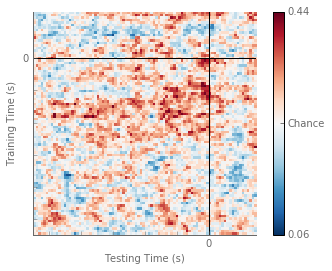

s03
['resplock_absdeviant', 'resplock_absdeviant']


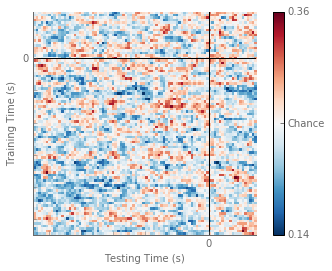

s04
['resplock_absdeviant', 'resplock_absdeviant']


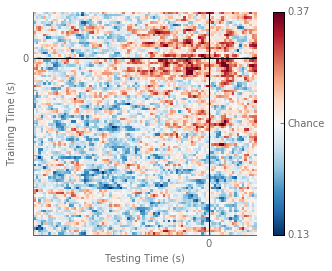

s05
['resplock_absdeviant', 'resplock_absdeviant']


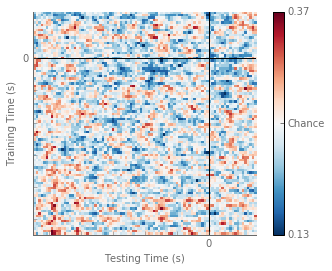

s06
['resplock_absdeviant', 'resplock_absdeviant']


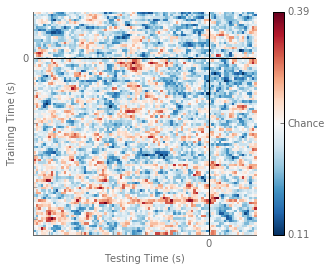

s07
['resplock_absdeviant', 'resplock_absdeviant']


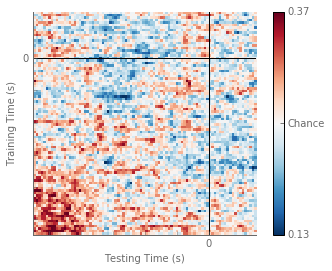

s08
['resplock_absdeviant', 'resplock_absdeviant']


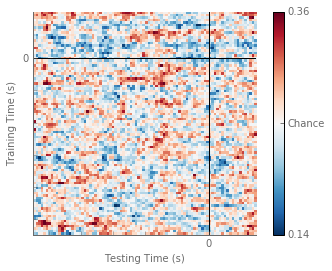

s09
['resplock_absdeviant', 'resplock_absdeviant']


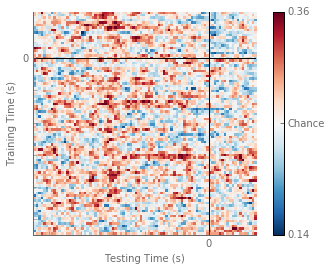

s10
['resplock_absdeviant', 'resplock_absdeviant']


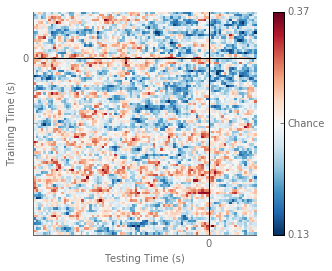

s11
['resplock_absdeviant', 'resplock_absdeviant']


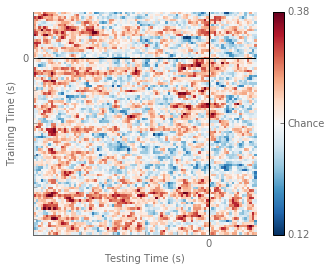

s12
['resplock_absdeviant', 'resplock_absdeviant']


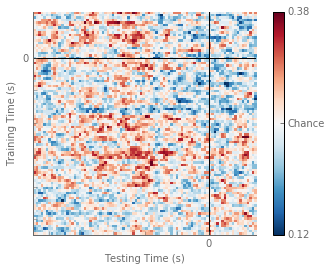

s13
['resplock_absdeviant', 'resplock_absdeviant']


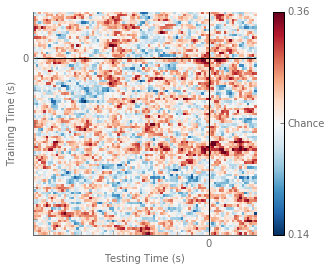

s14
['resplock_absdeviant', 'resplock_absdeviant']


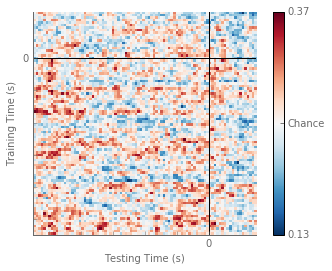

s15
['resplock_absdeviant', 'resplock_absdeviant']


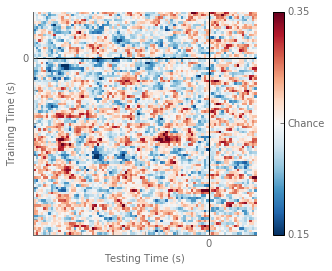

s16
['resplock_absdeviant', 'resplock_absdeviant']


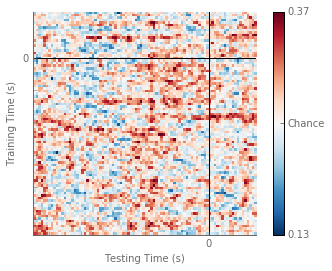

s17
['resplock_absdeviant', 'resplock_absdeviant']


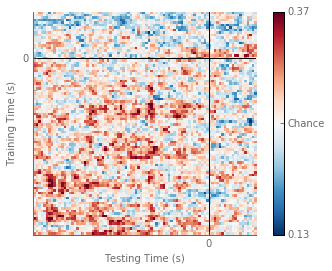

s18
['resplock_absdeviant', 'resplock_absdeviant']


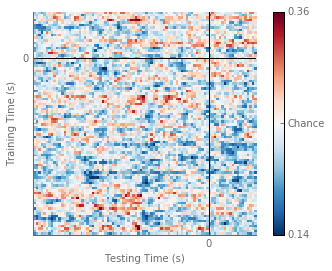

s19
['resplock_absdeviant', 'resplock_absdeviant']


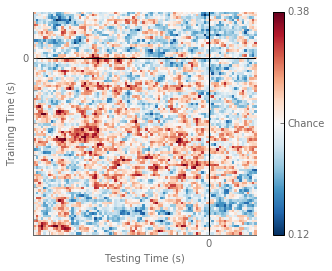

s21
['resplock_absdeviant', 'resplock_absdeviant']


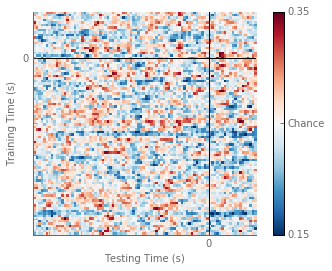

In [11]:
#Plot original GAT - individual subjects
for c, cond in enumerate(conditions):
    for s, sub in enumerate(subjects):
        print(sub)
        print(cond)
        pretty_gat(all_scores[c, s,:,:], times=times, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = None, colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 125, test_times = None)
             
        plt.show()

['resplock_absdeviant', 'resplock_absdeviant']


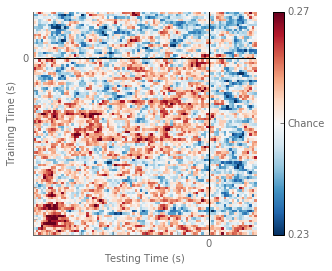

In [12]:
#Plot original GAT - group
for c, cond in enumerate(conditions):
    print(cond)
    pretty_gat(group_scores[c, 0:300, 0:300], times=times,chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = None, colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 125, test_times = None)
    plt.show()

In [ ]:
#Plot GAT with uncorrected p values
for c, cond in enumerate(conditions):
    classLines = [None, None, toi, toi]
    pretty_gat(group_scores[c, :, :], chance = .25, ax = None, sig = None, cmap = 'RdBu_r',
             colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 125, test_times = None)
    fname = dirs['gp_result'] + '/' + cond[0] + '_' + cond[1] + '-uncorrectedGAT.tif'
    #plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
    plt.show()

['resplock_absdeviant', 'resplock_absdeviant']


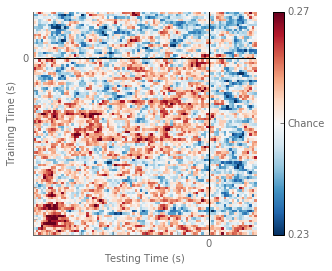

In [13]:
#Plot GAT with corrected p values - only contour
for c, cond in enumerate(conditions):
    classLines = [None, None, toi, toi]
    print(cond)
    pretty_gat(group_scores[c, :, :], times=times, chance = chance, ax = None, sig = p_values_gat_fdr[c,:]<0.05, cmap = 'RdBu_r',
             colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 125, test_times = None)
    fname = dirs['gp_result'] + cond[0] + '_' + cond[1] + '/' + cond[0] + '_' + cond[1] + 'group_gat_corrected.png'
    plt.savefig(fname, dpi = 600)
    plt.show()

['resplock_absdeviant', 'resplock_absdeviant']


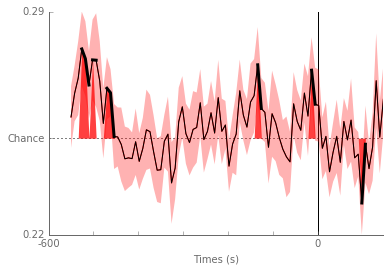

In [18]:
#Plot diagonal with corrected p values
for c, cond in enumerate(conditions):
        print (cond)
        #print(times[np.where(p_values_diagonal[c, :] < .05)])
        pretty_decod(all_diagonals[c, :, :], times=times, chance=chance, sig=p_values_diagonal_fdr[c, :]<0.05,
                 color=[1,0,0], fill=True, xlabel='Times (s)', sfreq=sfreq)
        fname = dirs['gp_result'] + cond[0] + '_' + cond[1] + '/' + cond[0] + '_' + cond[1] + 'group_diagonal_corrected.png'
        plt.savefig(fname, dpi = 600)
        
        plt.show()

In [ ]:
#Plot decoding with uncorrected p values
for c, cond in enumerate(conditions):
        print (cond)
        print(time[np.where(p_values_diagonal[c, :] < .05)])
        pretty_decod(all_diagonals[c, :, :], times=time, chance=chance, ax=None, width=20.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.02, scat=True, line=False, smoothWindow=8, lim = [-0.05, 0.15], thickness = 2, thicknessScat=40, schrift = 14)
        fname = dirs['gp_result'] + '/' + cond[0] + '_' + cond[1] + '-correctedDiag_smooth.tif'
        #plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
        
        plt.show()

In [ ]:
####################Plot diagonal in time bins####################
#Load important libraries
import matplotlib.pyplot as plt

#Define important variables
n_bins = len(timeBins)
font = {'fontname': 'Arial', 'fontsize': 14}

colors_blind = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
               (0.0, 0.4470588235294118, 0.6980392156862745),
               (0.0, 0.6196078431372549, 0.45098039215686275),
                (0.8352941176470589, 0.3686274509803922, 0.0),]

xLabels = ['Early', 'P3b', 'bDis', 'aDis']

x = np.arange(n_bins)
index = np.arange(n_bins)

for c, cond in enumerate(conditions):
    ax = plt.gca()
    print(cond)
        
    ax.bar(x, np.mean(group_diagonal_AVG[c, :, :], 1), alpha = 0.8, color = colors_blind)
        
    print(np.mean(group_diagonal_AVG[c, 0, :]), 1)
    print(sem_group_diagonal_AVG[c, 0])
        
    print(np.mean(group_diagonal_AVG[c, 1, :]), 1)
    print(sem_group_diagonal_AVG[c, 1])
    
    print(np.mean(group_diagonal_AVG[c, 2, :]), 1)
    print(sem_group_diagonal_AVG[c, 2])
    
    print(np.mean(group_diagonal_AVG[c, 3, :]), 1)
    print(sem_group_diagonal_AVG[c, 3])
        
    print(p_values_group_diagonal_AVG[c, 0])
    print(p_values_group_diagonal_AVG[c, 1])
    print(p_values_group_diagonal_AVG[c, 2])
    print(p_values_group_diagonal_AVG[c, 3])
        
    for pos, y, err, color in zip(x, np.mean(group_diagonal_AVG[c, :, :], 1), sem_group_diagonal_AVG[c, :], colors_blind):
        ax.errorbar(pos + 0.4, y, err, lw = 2, capsize = 5, color = color)

    #Plot chance level
    plt.axhline(0.0, color = 'k', ls = '--')

    #Take care of axes
    ax.margins(0.05) #spacing at the 
    ax.set_xticks(index + 0.4)
    ax.set_xticklabels(xLabels)
    ax.set_ylim([-0.1, 0.2])
    plt.show()

In [ ]:
#Select subset of time window
#Identify the index
ind = np.where(time == ttp[0])
ind = int(ind[0][0])

#Cut all of the data
time = time[ind :]
all_diagonals = all_diagonals[:, :, ind :]
all_scores = all_scores[:, :, ind :, ind :]

In [ ]:
#Compute time averages for diagonal
timeBins = [[0.1, 0.3], [0.3, 0.6], [0.6, 1.6], [1.6, 2.532]]
group_diagonal_AVG = np.zeros((len(conditions), len(timeBins), len(subjects)))
sem_group_diagonal_AVG = np.zeros((len(conditions), len(timeBins)))

for c, cond in enumerate(conditions):
    for tb, timebin in enumerate(timeBins):
        #Identify the index
        ind1 = np.where(time == timeBins[tb][0])
        ind1 = int(ind1[0][0])
        ind2 = np.where(time == timeBins[tb][1])
        ind2 = int(ind2[0][0])

        group_diagonal_AVG[c, tb, :] = np.mean(all_diagonals[c, :,  ind1 : ind2], 1)
        sem_group_diagonal_AVG[c, tb] = stats.sem(np.mean(all_diagonals[c, :, ind1 : ind2], 1), 0)

In [ ]:
 #Compute stats for averaged diagonal
p_values_group_diagonal_AVG = np.zeros((len(conditions), len(timeBins)))

for c, cond in enumerate(conditions):
    for tb, timebin in enumerate(timeBins):
        p_values_group_diagonal_AVG[c, tb] = parallel_stats(group_diagonal_AVG[c, tb, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
        p_values_group_diagonal_AVG[c, tb] = p_values_group_diagonal_AVG[c, tb]/2.   